### Student Information

Name: Samuel Dharma

Student ID: 110006223

GitHub ID: 127833575

Kaggle name: samueldharma

Kaggle private scoreboard snapshot:
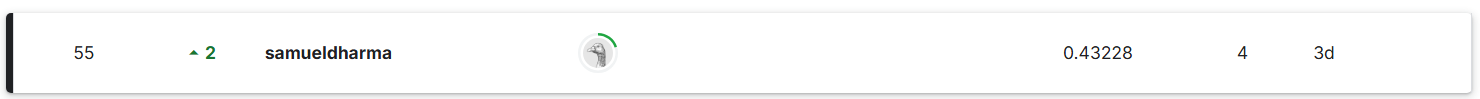


---


### Instructions


1. First: **This part is worth 30% of your grade.** Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook.

2. Second: **This part is worth 30% of your grade.** Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking:

   - **Bottom 40%**: Get 20% of the 30% available for this section.

   - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) _ 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 _ 100 + 1 - 3) / (0.6 _ 100) _ 10 + 20 = 29.67% out of 30%.)  
     Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.

3. Third: **This part is worth 30% of your grade.** A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.

4. Fourth: **This part is worth 10% of your grade.** It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.

Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**.


## **Imports and Libraries**


In [2]:
import pandas as pd
import json
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

## **Data Loading and Preprocessing**

1. **Load Data**:

   - **Tweets Dataset**: Extract `tweet_id`, `text`, and `hashtags` from `tweets_DM.json` into a DataFrame.
   - **Emotion Labels**: Load `emotion.csv` containing emotion annotations.
   - **Identification Labels**: Load `data_identification.csv` indicating training or test split.

2. **Merge Datasets**:

   - Combine tweets with identification and emotion labels using `tweet_id`.

3. **Split Data**:
   - **`train_df`**: Tweets marked for training.
   - **`test_df`**: Tweets marked for testing.


In [3]:
### Begin Assignment Here
import pandas as pd
import json

# Load the JSON file containing tweets
tweets = []
with open('./data/tweets_DM.json', 'r', encoding='utf-8') as f:
    for line in f:
        tweets.append(json.loads(line))

tweets_df = pd.DataFrame([{
    'tweet_id': item['_source']['tweet']['tweet_id'],
    'text': item['_source']['tweet']['text'],
    'hashtags': item['_source']['tweet']['hashtags']
} for item in tweets])

# Load the emotion and identification datasets
emotion_df = pd.read_csv('./data/emotion.csv')
identification_df = pd.read_csv('./data/data_identification.csv')

# Merge datasets
merged_df = pd.merge(tweets_df, identification_df, on='tweet_id')
merged_df = pd.merge(merged_df, emotion_df, on='tweet_id', how='left')

# Separate train and test data
train_df = merged_df[merged_df['identification'] == 'train']
test_df = merged_df[merged_df['identification'] == 'test']

print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")
train_df.head()


Train set: (1455563, 5)
Test set: (411972, 5)


,tweet_id,text,hashtags,identification,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat],train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]",train,sadness
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,[],train,fear
5,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,"[authentic, LaughOutLoud]",train,joy
6,0x2c91a8,Still waiting on those supplies Liscus. <LH>,[],train,anticipation


### **Text Preprocessing**

1. **Import Libraries**:

   - **`re`**: For text cleaning using regular expressions.
   - **NLTK Tools**:
     - `word_tokenize`: Tokenizes text into words.
     - `stopwords`: Provides a list of common English stopwords.
     - `WordNetLemmatizer`: Lemmatizes words to their base forms.

2. **Download NLTK Data**:

   - Ensure the required NLTK datasets (`punkt`, `stopwords`, `wordnet`) are downloaded.

3. **Text Cleaning Function**:

   - **Purpose**: Prepares text for analysis by removing noise and standardizing content.
   - **Steps**:
     - Remove specific tokens (`<LH>`, hashtags, mentions, and special characters).
     - Convert text to lowercase.
     - Tokenize into words.
     - Remove stopwords and lemmatize tokens.
     - Return cleaned text as a single string.

4. **Apply Cleaning**:
   - **Train Data**: Clean the `text` column in `train_df` and save it as a new column `clean_text`.
   - **Test Data**: Perform the same cleaning process for the `text` column in `test_df`.


In [4]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Text cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<LH>', '', text)  # Remove <LH>
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(tokens)

# Apply cleaning to train and test sets
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)


[nltk_data] Downloading package punkt to C:\Users\Samuel
[nltk_data]     Sukatja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Samuel
[nltk_data]     Sukatja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Samuel
[nltk_data]     Sukatja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Samuel Sukatja\AppData\Local\Temp\ipykernel_17904\2435772633.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['clean_text'] = train_df['text'].apply(clean_text)
C:\Users\Samuel Sukatja\AppData\Local\Temp\ipykernel_17904\2435772633.py:28: S

I count the total vocabulary size of the 'clean_text'


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(train_df['clean_text'])
vocab_size = len(vectorizer.get_feature_names_out())
print(f"Total Vocabulary Size: {vocab_size}")


Total Vocabulary Size: 246719


## **Model + Feature Engineering**


### **Bag-of-Words and Hyperparameter Tuning + MNB**

1. **Data Split**:

   - Split `train_df` into training and validation sets using `train_test_split` (80% train, 20% validation).

2. **Pipeline**:

   - **`CountVectorizer`**: Converts text to Bag-of-Words features.
   - **`MultinomialNB`**: Naive Bayes classifier.

3. **Parameter Grid**:

   - Tune `max_features` in `CountVectorizer` with values: `[100000, 150000, 200000, 250000, 500000, 1000000]`.

4. **Grid Search**:

   - Perform 5-fold cross-validation to find the best `max_features` using `GridSearchCV`.
   - Optimize for `accuracy` and log progress with `verbose=1`.

5. **Results**:
   - Display the best parameter (`max_features`) and the highest cross-validation accuracy.


In [ ]:
# Create validation set from train_df
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_text'], train_df['emotion'], test_size=0.2, random_state=42
)

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Define the parameter grid for max_features
param_grid = {
    'vectorizer__max_features': [100000, 150000, 200000, 250000, 500000, 1000000]
}

# Perform Grid Search
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1, 
    return_train_score=True  # Ensure this is set to include training scores
)

grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'vectorizer__max_features': 200000}
Best Cross-Validation Accuracy: 0.4700


In [ ]:
# Retrieve results
results = grid_search.cv_results_

# Extract training and validation accuracies for each max_features value
train_scores = results['mean_train_score']
val_scores = results['mean_test_score']
max_features = param_grid['vectorizer__max_features']

# Output accuracies
print("max_features | Training Accuracy | Validation Accuracy")
for mf, train_acc, val_acc in zip(max_features, train_scores, val_scores):
    print(f"{mf:<12} | {train_acc:.4f}           | {val_acc:.4f}")



max_features | Training Accuracy | Validation Accuracy
100000       | 0.5089           | 0.4685
150000       | 0.5166           | 0.4697
200000       | 0.5198           | 0.4700
250000       | 0.5198           | 0.4700
500000       | 0.5198           | 0.4700
1000000      | 0.5198           | 0.4700


**Observations**:

- Training accuracy stabilizes at higher `max_features` values.
- Validation accuracy peaks at 200,000 and does not improve beyond this.


### **Model Evaluation and Results**

1. **Best Parameters**:

   - Optimal `max_features`: **200,000**
   - Best Cross-Validation Accuracy: **0.4700**

2. **Validation Set Performance**:

   - **Model**: Evaluate the best pipeline on the validation set using `accuracy_score` and `classification_report`.

3. **Performance Metrics**:
   - **Accuracy**: **0.4709**
   - **Class-wise Metrics**:
     - Precision, recall, and F1-score for each emotion (high recall for `joy` but lower performance for `anger` and `surprise`).
   - **Macro Avg**: **F1-score: 0.34**, highlighting class imbalance challenges.
   - **Weighted Avg**: **F1-score: 0.44**, reflecting overall model performance.


In [16]:
# Best results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_val_pred)

print("\nValidation Set Performance:")
print(classification_report(y_val, y_val_pred))
print(f"Validation Accuracy: {validation_accuracy:.4f}")

Best Parameters: {'vectorizer__max_features': 200000}
Best Cross-Validation Accuracy: 0.4700

Validation Set Performance:
              precision    recall  f1-score   support

       anger       0.77      0.08      0.15      7946
anticipation       0.52      0.47      0.49     49984
     disgust       0.37      0.28      0.32     27669
        fear       0.72      0.21      0.33     12846
         joy       0.48      0.78      0.59    102943
     sadness       0.38      0.37      0.38     38745
    surprise       0.79      0.11      0.19      9816
       trust       0.46      0.17      0.25     41164

    accuracy                           0.47    291113
   macro avg       0.56      0.31      0.34    291113
weighted avg       0.49      0.47      0.44    291113

Validation Accuracy: 0.4709


### **TF-IDF Vectorizer with Hyperparameter Tuning + MNB**

1. **Pipeline**:

   - Uses `TfidfVectorizer` for text representation and `MultinomialNB` for classification.

2. **Parameter Grid**:

   - Tests combinations of `ngram_range`, `min_df`, `max_df`, `max_features`, and `alpha`.

3. **Results**:

   - **Best Parameters**: Optimal configuration for TF-IDF and Naive Bayes.
   - **Best Cross-Validation Accuracy**: Reported during grid search.

4. **Validation Performance**:
   - **Accuracy**: Displays the validation accuracy.
   - **Classification Report**: Shows precision, recall, and F1-score for each emotion.


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],  # Unigrams or unigrams + bigrams
    'tfidf__max_features': [200000],  # Vocabulary size
    'tfidf__min_df': [1, 5, 10],  # Minimum document frequency for words
    'tfidf__max_df': [0.5, 0.75, 1.0],  # Maximum document frequency
    'nb__alpha': [0.1, 0.5, 1.0]  # Laplace smoothing parameter
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Output the best parameters and scores
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate on the validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_val_pred)

print("\nValidation Set Performance:")
print(classification_report(y_val, y_val_pred))
print(f"Validation Accuracy: {validation_accuracy:.4f}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\Samuel Sukatja\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'nb__alpha': 0.5, 'tfidf__max_df': 0.5, 'tfidf__max_features': 200000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}
Best Cross-Validation Accuracy: 0.4869

Validation Set Performance:
              precision    recall  f1-score   support

       anger       0.92      0.09      0.16      7946
anticipation       0.60      0.46      0.52     49984
     disgust       0.40      0.26      0.31     27669
        fear       0.78      0.22      0.35     12846
         joy       0.48      0.83      0.61    102943
     sadness       0.40      0.38      0.39     38745
    surprise       0.93      0.11      0.20      9816
       trust       0.53      0.19      0.28     41164

    accuracy                           0.49    291113
   macro avg       0.63      0.32      0.35    291113
weighted avg       0.53      0.49      0.45    291113

Validation Accuracy: 0.4897


### **TF-IDF Model Results**

1. **Grid Search Process**:

   - Evaluated 162 parameter combinations across 5 folds, resulting in 810 fits.
   - Encountered a runtime warning but completed the search.

2. **Best Parameters**:

   ```
   {'nb__alpha': 0.5, 'tfidf__max_df': 0.5, 'tfidf__max_features': 200000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}
   ```

3. **Performance**:

   - **Cross-Validation Accuracy**: **0.4869**
   - **Validation Accuracy**: **0.4897**

4. **Validation Classification Report**:
   - **Strengths**: High precision for `anger` and `surprise`.
   - **Weaknesses**: Low recall for most emotions except `joy`.
   - **Macro Avg F1-Score**: **0.35**
   - **Weighted Avg F1-Score**: **0.45**


### **TF-IDF + MNB with Unprocessed Text**

1. Now we want to test model performance using raw text without preprocessing.

2. **Process**:
   - Split raw text into training and validation sets.
   - Use `TfidfVectorizer` with optimal parameters from grid search.
   - Train `MultinomialNB` with `alpha=0.5`.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create validation set from train_df
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    train_df['text'], train_df['emotion'], test_size=0.2, random_state=42
)

# Extract features using TfidfVectorizer with best parameters
vectorizer = TfidfVectorizer(
    max_df=0.5, 
    max_features=235020, 
    min_df= 1, 
    ngram_range=(1, 3)
)

# Transform the training and validation data
X_train = vectorizer.fit_transform(X_train_raw)
X_val = vectorizer.transform(X_val_raw)

# Train MultinomialNB with the best alpha
model = MultinomialNB(alpha=0.5)
model.fit(X_train, y_train)

# Calculate and print training accuracy
y_train_pred = model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.4f}")

# Calculate and print validation accuracy
y_val_pred = model.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {validation_accuracy:.4f}")


Training Accuracy: 0.5952
Validation Accuracy: 0.5455


Surprisingly, the model performs better with unprocessed text, meaning that raw text may retain valuable context for this dataset.


### **Final Model Training and Test Prediction**

1. Now we train the model on the entire training dataset and make predictions on the test dataset.

2. **Process**:

   - **Training Data**:
     - Text: `train_df['text']`
     - Labels: `train_df['emotion']`
   - **Test Data**:
     - Text: `test_df['text']`
     - IDs: `test_df['tweet_id']`
   - **Vectorization**: Use `TfidfVectorizer` with:
     - Parameters: `max_df=0.5`, `max_features=235020`, `min_df=1`, `ngram_range=(1, 3)`
     - Additional: Stop word removal and sublinear term frequency scaling.
   - **Model**: Train `MultinomialNB` with `alpha=0.5`.

3. **Results**:

   - **Training Accuracy**: Evaluate the model on the training set.
   - **Test Predictions**: Generate emotion predictions for the test set.

4. **Submission**:
   Create a submission file (`submission.csv`) with columns:
   - `id`: Tweet IDs from the test dataset.
   - `emotion`: Predicted emotion labels.


In [ ]:
# Extract training data
X_train_raw = train_df['text']
y_train = train_df['emotion']

# Extract test data
X_test_raw = test_df['text']
test_ids = test_df['tweet_id']

# Vectorize the text data using TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=0.5,
    max_features=235020,
    min_df=1,
    ngram_range=(1, 3),
    stop_words='english',
    sublinear_tf=True
)

# Transform the training and test data
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

# Train the MultinomialNB model
model = MultinomialNB(alpha=0.5)
model.fit(X_train, y_train)

# Calculate training accuracy
y_train_pred = model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.4f}")

# Make predictions on the test data
test_predictions = model.predict(X_test)

# Prepare the submission file
submission = pd.DataFrame({
    'id': test_ids,
    'emotion': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created!")

Training Accuracy: 0.5938
Submission file 'submission.csv' created!


We see the Results of Training Accuracy is 0.5938 and Submission file (submission.csv) generated with predictions.
